In [39]:
from IPython.display import Image
# 啟動互動式繪圖環境
%pylab inline
import numpy as np
from sklearn import mixture
import pandas as pd
import datetime
import numpy as np
import random as rd
import math
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


#Machine Learning 2015 Final Project

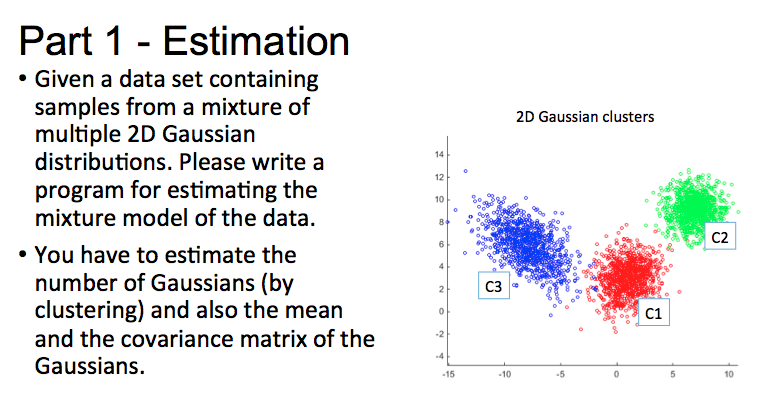

In [2]:
Image(filename='/Users/wy/Desktop/Part 1 - Estimation.png') 

In [5]:
testData_gaussianClusters2D = "/Users/wy/Desktop/MLfinalproject/data_txt/testData_gaussianClusters2D.txt"
trainData_gaussianClusters2D = "/Users/wy/Desktop/MLfinalproject/data_txt/trainData_gaussianClusters2D..txt"
verificationData_gaussianClusters2D = "/Users/wy/Desktop/MLfinalproject/data_txt/verificationData_gaussianClusters2D.txt"
    
def loaddata():
    x1 = []; y1 = []; x2 = []; y2 = []; x3 = []; y3 = [];   
    for path in [testData_gaussianClusters2D,trainData_gaussianClusters2D,verificationData_gaussianClusters2D]:
        with open(path, 'r') as f:
            read_data = f.readlines()
        for line in read_data:
            line = line.strip()
            line = line.split(',')
            if line[2] == '1':
                x1.append(float(line[0]))
                y1.append(float(line[1]))            
            elif line[2] == '2':
                x2.append(float(line[0]))
                y2.append(float(line[1]))
            elif line[2] == '3':
                x3.append(float(line[0]))
                y3.append(float(line[1]))
        return x1,y1,x2,y2,x3,y3

##載入dataset
分別從三個檔案testData_gaussianClusters2D,trainData_gaussianClusters2D,verificationData_gaussianClusters2D
合在一起畫成的圖

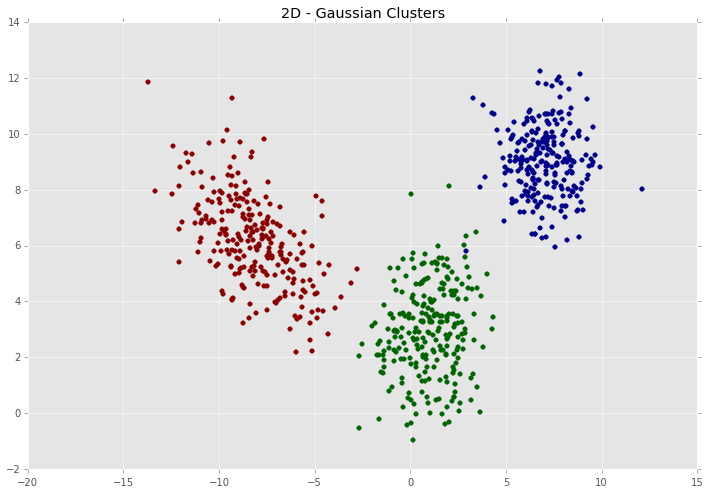

In [17]:
fig = plt.figure(figsize=(12, 8))
x1,y1,x2,y2,x3,y3 = loaddata()
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, y1, color="DarkGreen")
ax.scatter(x2, y2, color="DarkBlue")
ax.scatter(x3, y3, color="DarkRed")
ax.set_title("2D - Gaussian Clusters")

## Gaussian Mixture Model
透過GMM學習出機率密度來去判斷，每一個被assign到K群的機率，是屬於soft assignment  
每個GMM由k個Gaussian分佈組成(假設分為k群)，每一個Gaussian分佈被稱為Component，透過線性疊加就組成GMM機率密度函數
###$p(x) = \sum_{k=1}^{K}p(k)p(x|k) = \sum_{k=1}^{K} \pi ^{k}N(x|\mu ^{k},\Sigma  ^{k})$  
  
隨機從K的Gaussian Component選一個的機率為p(k)，選中其Component之後，再從這分佈中取點  
假設有N的點，並服從某個分佈$ \pi ^{k}$，在GMM中其他參數，各類平均值$\mu ^{k}$和各個協方差$\Sigma  ^{k}$，如果能夠找到一組參數，使得機率分佈下給定的點機率最大。  

Step1:  
先估計數據由每個Component生成的機率，對於$x_{i}$來說它由第k個Component生成的機率為： 
###$\gamma (i,k) = \frac{ \pi_{k}N(x_{i}|\mu ^{k},\Sigma  ^{k})}{ \sum_{j=1}^{K}\pi_{j}N(x_{i}|\mu ^{j},\Sigma  ^{j})}$
###$N(x|\mu ,\Sigma ) = \frac{1}{2\pi ^{\frac{D}{2}}} \frac{1}{|\Sigma |^{\frac{1}{2}}}e^{-\frac{1}{2}(x-\mu )^{T}\Sigma ^{-1}(x-\mu )}$
Step2:  
####更新參數$ \pi ^{k}$，$\mu ^{k}$，$\Sigma  ^{k}$  
###$\mu _{k} = \frac{1}{N_{k}}\sum_{i=1}^{N} \gamma (i,k)x_{i}$

###$\Sigma _{k} = \frac{1}{N_{k}} \sum_{i=1}^{N} \gamma (i,k)(x_{i}-\mu _{k})(x_{i}-\mu _{k})^{T}$
###其中$N_{k} = \sum_{i=1}^{N}\gamma (i,k)$，$ \pi ^{k}$ = $ \frac{N_{k}}{N}$
Step3:  
重覆迭代直到收斂

### 程式碼如下，皆會對應到上述公式

In [35]:
def initialize(K, data):
    '''
    初始化 mu,sigma,pi
    '''
    # d -> dimensions 
    d = data.shape[1]
    
    # initialize the mu randomly 0-10
    mu = np.random.rand(K,d)*10
  
    # initialize the sigma
    sigma = []
    for k in range(K):
        sigma.append(np.cov(data.T))
 
    # initialize the pi 
    sum_pi = 1.0
    pi = np.zeros(K)
    pi += sum_pi/K
    return mu, sigma, pi
 
def e_step(K,mu,sigma,pi,data): 
    '''
    用現有的 mu,sigma,pi 估計該點屬於K群的機率
    '''
    N = len(data)
    r = np.zeros((N,K))
 
    for i in range(N):
        for k in range(K):
            r[i][k] = (pi[k]*prior_prob(data[i],mu[k],sigma[k]))/prior_prob_sigmak(K,mu,sigma,pi,data[i])
 
    return r
 
def m_step(r, K, data):
    '''
    用該點屬於K群的機率 估計mu,sigma,pi
    '''
    # update mu
    N = len(data)
    N_k = np.zeros(K)  
    d = data.shape[1]
    new_mu = np.zeros((K,d))
    
    for k in range(K):
        for n in range(N):
            N_k[k] += r[n][k]
            new_mu[k] += (r[n][k]*data[n])
 
        new_mu[k] /= N_k[k]
 
    # update sigma
    new_sigma = np.zeros((K,d,d))
    for k in range(K):  
        for n in range(N):
            xn = np.zeros((1,2))
            mun = np.zeros((1,2))
            xn += data[n]
            mun += new_mu[k]
            x_mu = xn - mun
            new_sigma[k] += (r[n][k]*x_mu*x_mu.T)
        new_sigma[k] /= N_k[k]
 
    # update pi
    new_pi = np.zeros(3)
    for k in range(K):
        new_pi[k] += (N_k[k]/N)
 
    return new_mu, new_sigma, new_pi
 
def likelihood(K,mu,sigma,pi,data):
    """
    計算log likelihood 每個點對應每個K群的機率(取log)
    """
    N = len(data)
    log_score = 0.0
    for n in range(N):
        log_score += np.log(prior_prob_sigmak(K,mu,sigma,pi,data[n]))
    return log_score
 
def prior_prob_sigmak(K,mu,sigma,pi,data):
    """
    計算後驗機率*k群機率
    """
    pb = 0.0
    for k in range(K):        
        pb += pi[k]*prior_prob(data,mu[k],sigma[k])
 
    return pb
 
def prior_prob(x,mu,sigma):
    """
    計算後驗機率 
    """
    score = 0.0
 
    x_mu = np.matrix(x - mu)
    inv_sigma = np.linalg.inv(sigma)
    det_sqrt = np.linalg.det(sigma)**0.5
    d = len(x)
    norm_const = 1.0/((2*np.pi)**(d/2)*det_sqrt)
    exp_value = math.pow(math.e,-0.5 * (x_mu * inv_sigma * x_mu.T))
    score = norm_const * exp_value
    
    return score

def predict(data,K,mu_k,sigma_k):
    """
    預測屬於哪一群
    """
    label = []
    for i in range(len(data)):
        prior_prob_k = [prior_prob(data[i],mu[k],sigma[k]) for k in range(K)]
        label.append(prior_prob_k.index(max(prior_prob_k)))
    return label
            
def gmm(K,data):
    """
    gmm主函數
    """    
    mu, sigma, pi = initialize(K,data)
    log_score = likelihood(K, mu, sigma, pi, data)
    threshold = 0.001
    i = 0
    max_iter = 500
    while i < max_iter:
        # expectation step
        r = e_step(K,mu,sigma,pi,data)
 
        # maximization step
        mu, sigma, pi = m_step(r, K, data)
        
        new_log_score = likelihood(K, mu, sigma, pi, data)
        if abs(new_log_score - log_score) < threshold:
            break
        log_score = new_log_score
 
        i += 1
    print "num_iter"
    print i
    return mu,sigma

num_iter
23
run time
0:00:27.514949


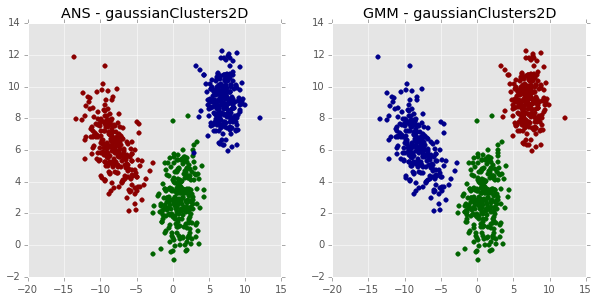

In [36]:
fig = plt.figure(figsize=(10, 10))

# 原本data所分出來的群
x1,y1,x2,y2,x3,y3 = loaddata()
ax = fig.add_subplot(2,2,1)
ax.scatter(x1, y1, color="DarkGreen")
ax.scatter(x2, y2, color="DarkBlue")
ax.scatter(x3, y3, color="DarkRed")
ax.set_title("ANS - gaussianClusters2D")

# GMM所分出來的群
data = np.array([[a,b] for a,b in zip(x1+x2+x3,y1+y2+y3)])
start = datetime.datetime.now()
mu,sigma = gmm(3,data)
end = datetime.datetime.now()
print "run time"
print end - start
plabel = predict(data,3,mu,sigma)

x1 = []; y1 = []; x2 = []; y2 = []; x3 = []; y3 = [];
for a,b in zip(data,plabel):
    if b == 0:
        x1.append(a[0])
        y1.append(a[1])            
    elif b == 1:
        x2.append(a[0])
        y2.append(a[1])
    elif b == 2:
        x3.append(a[0])
        y3.append(a[1])        
        
ax = fig.add_subplot(2,2,2)
ax.scatter(x1, y1, color="DarkGreen")
ax.scatter(x2, y2, color="DarkBlue")
ax.scatter(x3, y3, color="DarkRed")
ax.set_title("GMM - gaussianClusters2D")

###mean 

In [37]:
mu

array([[ 0.99901127,  2.96957753],
       [-8.18389846,  6.17044364],
       [ 7.04130414,  9.04433644]])

###covariance 

In [38]:
sigma

array([[[ 2.02419971,  0.32932928],
        [ 0.32932928,  2.69458581]],

       [[ 3.89716884, -1.87204675],
        [-1.87204675,  2.72424124]],

       [[ 1.63694555, -0.04410821],
        [-0.04410821,  1.56895607]]])

### 番外篇  
很好奇我寫的超簡單GMM演算法和scikit-learn(python裡最強的ML library)比起來會是怎樣

In [ ]:

np.random.seed(1)
g = mixture.GMM(n_components=2)
# clusterincluster
x0,y0,x1,y1 = loaddata(path4)
data = np.array([[a,b] for a,b in zip(x0+x1,y0+y1)])
g.fit(data) 
plabel = list(g.predict(data))

fig = plt.figure(figsize=(16, 16))

x0 = []; y0 = []; x1 = []; y1 = []; 
for a,b in zip(data,plabel):
    if b == 0:
        x0.append(a[0])
        y0.append(a[1])            
    elif b == 1:
        x1.append(a[0])
        y1.append(a[1])
        

ax = fig.add_subplot(4,2,2)
ax.scatter(x0, y0, color="DarkGreen")
ax.scatter(x1, y1, color="DarkBlue")
ax.set_title("GMM - clusterincluster")

num_iter
21
run time
0:00:23.982859
run time
0:00:00.022642


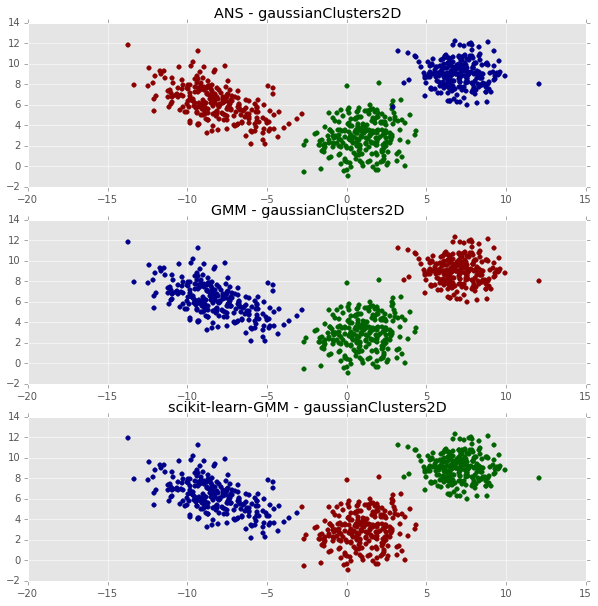

In [41]:
fig = plt.figure(figsize=(10, 10))

# 原本data所分出來的群
x1,y1,x2,y2,x3,y3 = loaddata()
ax = fig.add_subplot(3,1,1)
ax.scatter(x1, y1, color="DarkGreen")
ax.scatter(x2, y2, color="DarkBlue")
ax.scatter(x3, y3, color="DarkRed")
ax.set_title("ANS - gaussianClusters2D")

# GMM所分出來的群
data = np.array([[a,b] for a,b in zip(x1+x2+x3,y1+y2+y3)])
start = datetime.datetime.now()
mu,sigma = gmm(3,data)
end = datetime.datetime.now()
print "run time"
print end - start
plabel = predict(data,3,mu,sigma)

x1 = []; y1 = []; x2 = []; y2 = []; x3 = []; y3 = [];
for a,b in zip(data,plabel):
    if b == 0:
        x1.append(a[0])
        y1.append(a[1])            
    elif b == 1:
        x2.append(a[0])
        y2.append(a[1])
    elif b == 2:
        x3.append(a[0])
        y3.append(a[1])        
        
ax = fig.add_subplot(3,1,2)
ax.scatter(x1, y1, color="DarkGreen")
ax.scatter(x2, y2, color="DarkBlue")
ax.scatter(x3, y3, color="DarkRed")
ax.set_title("GMM - gaussianClusters2D")

# scikit-learn - GMM所分出來的群

data = np.array([[a,b] for a,b in zip(x1+x2+x3,y1+y2+y3)])
start = datetime.datetime.now()
np.random.seed(1)
g = mixture.GMM(n_components=3)
g.fit(data) 
end = datetime.datetime.now()
print "run time"
print end - start
plabel = list(g.predict(data))

x1 = []; y1 = []; x2 = []; y2 = []; x3 = []; y3 = [];
for a,b in zip(data,plabel):
    if b == 0:
        x1.append(a[0])
        y1.append(a[1])            
    elif b == 1:
        x2.append(a[0])
        y2.append(a[1])
    elif b == 2:
        x3.append(a[0])
        y3.append(a[1])        
        
ax = fig.add_subplot(3,1,3)
ax.scatter(x1, y1, color="DarkGreen")
ax.scatter(x2, y2, color="DarkBlue")
ax.scatter(x3, y3, color="DarkRed")
ax.set_title("scikit-learn-GMM - gaussianClusters2D")

In [47]:
print "scikit-learn - means"
print g.means_
print "GMM - means"
print mu

scikit-learn - means
[[ 7.03865202  9.04304499]
 [-8.22062447  6.18976348]
 [ 0.96912611  2.96964848]]
GMM - means
[[ 0.99892736  2.96957508]
 [-8.18402411  6.17050518]
 [ 7.04129422  9.0443326 ]]


In [46]:
print "scikit-learn - covariance"
print g.covars_
print "GMM - covariance"
print sigma

scikit-learn - covariance
[[ 1.64667814  1.57157383]
 [ 3.72885931  2.68093425]
 [ 2.12379662  2.67599307]]
GMM - covariance
[[[ 2.02443345  0.32925317]
  [ 0.32925317  2.69452381]]

 [[ 3.89653151 -1.87173072]
  [-1.87173072  2.72408737]]

 [[ 1.63698081 -0.04409395]
  [-0.04409395  1.56895952]]]


### 比較結果
基本上means和covariance所算出來的結果都是一樣的，但是執行速度上來說
可是落後一大截23s v.s 0.02s，原因是因為此library有透過其他方法加速其演算法  
(資料結構的部分和用log降低計算量)但是還是算成功，準確度是一樣的，演算法可以work!